In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns

In [3]:
df_calendar = pd.read_csv('calendar.csv')
df_calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [4]:
df_calendar.wm_yr_wk.unique().shape
# 282 weeks total (about 5 years)

(282,)

In [5]:
# wm_yr_wk is the unique ordinal number of the week, for all the years. 
# you have an unique value of wm_yr_wk for each 7 days, from Saturday to Friday.

In [6]:
df_validation = pd.read_csv('sales_train_validation.csv')
df_validation

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [7]:
df_validation

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [8]:
ex1 = df_validation[df_validation['id']=='FOODS_3_090_CA_3_validation']
ex1 = ex1.iloc[:,6:].T
ex1

,8412
d_1,108
d_2,132
d_3,102
d_4,120
d_5,106
...,...
d_1909,88
d_1910,77
d_1911,141
d_1912,139


<AxesSubplot:>

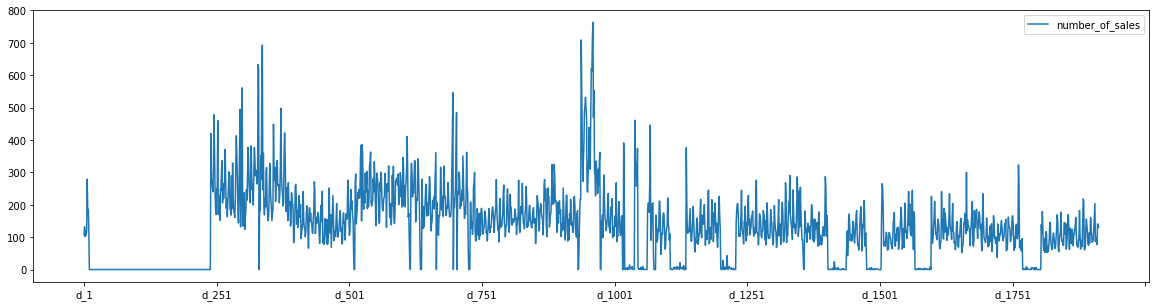

In [9]:
ex1 = ex1.rename(columns = {8412:'number_of_sales'})
ex1['d']= ex1.index
ex1.plot(figsize = (20,5))
#sns.lineplot(x = 'days', y = 'number of sales', data = ex1)

<AxesSubplot:xlabel='date'>

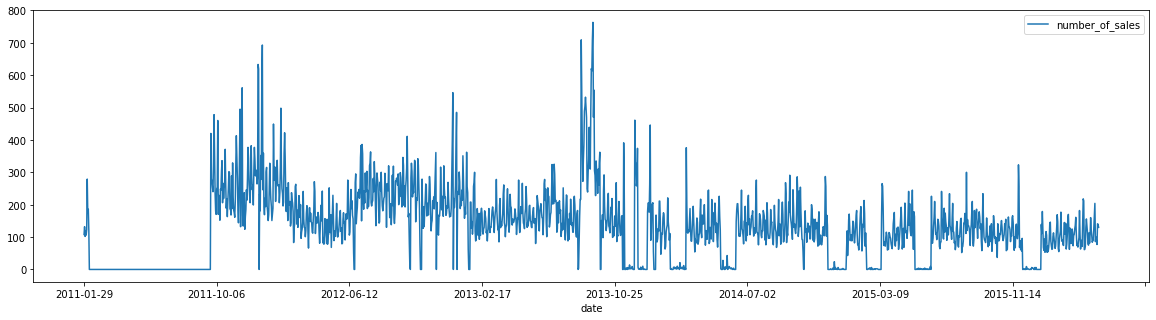

In [10]:
ex2 = pd.merge(df_calendar, ex1, on = 'd')
ex2 = ex2.set_index('date')
ex2.plot(figsize = (20,5), y='number_of_sales')

In [11]:
# see how the item is sold by different time periods (days, months, years)
ex2 # 'FOODS_3_090_CA_3_validation'

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,number_of_sales
date,,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,108
2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,132
2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,102
2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,120
2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,11612,Wednesday,5,4,2016,d_1909,NaN,NaN,NaN,NaN,0,0,0,88
2016-04-21,11612,Thursday,6,4,2016,d_1910,NaN,NaN,NaN,NaN,0,0,0,77
2016-04-22,11612,Friday,7,4,2016,d_1911,NaN,NaN,NaN,NaN,0,0,0,141


<AxesSubplot:title={'center':'FOODS_3_090_CA_3_validation'}, xlabel='month'>

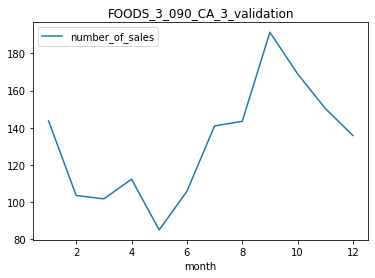

In [12]:
# after groupby, you have to apply some operations
ex2.groupby('month').mean().plot(y = 'number_of_sales', title = 'FOODS_3_090_CA_3_validation')

<AxesSubplot:title={'center':'FOODS_3_090_CA_3_validation'}, xlabel='wday'>

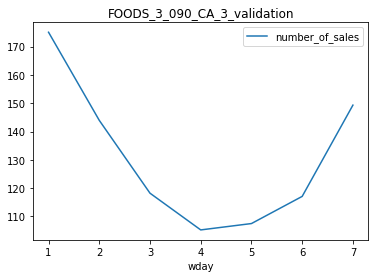

In [13]:
ex2.groupby('wday').mean().plot(y = 'number_of_sales', title = 'FOODS_3_090_CA_3_validation')

<AxesSubplot:title={'center':'FOODS_3_090_CA_3_validation'}, xlabel='year'>

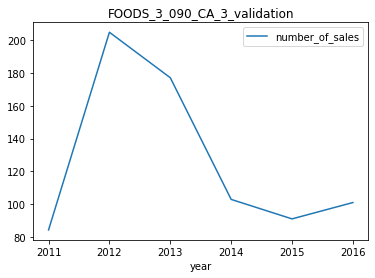

In [14]:
ex2.groupby('year').mean().plot(y = 'number_of_sales', title = 'FOODS_3_090_CA_3_validation')

In [15]:
d_col = []
for c in df_validation.columns:
    if 'd_' in c:
        d_col.append(c)

df_validation[df_validation['cat_id'] == 'HOBBIES'][df_validation['store_id']=='CA_3'][d_col].sum(axis=1).sort_values()
# found that 'HOBBIES_1_371_CA_3_validation' has quite a lot of sales compared to others

df_validation.iloc[6460]


<ipython-input-15-3947364e378b>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_validation[df_validation['cat_id'] == 'HOBBIES'][df_validation['store_id']=='CA_3'][d_col].sum(axis=1).sort_values()


id          HOBBIES_1_371_CA_3_validation
item_id                     HOBBIES_1_371
dept_id                         HOBBIES_1
cat_id                            HOBBIES
store_id                             CA_3
                        ...              
d_1909                                  9
d_1910                                 13
d_1911                                  4
d_1912                                 18
d_1913                                  8
Name: 6460, Length: 1919, dtype: object

In [16]:

ex3 = df_validation[df_validation['id'] == 'HOBBIES_1_371_CA_3_validation']
ex3 = ex3.set_index('id')[d_col]

ex3 = ex3.T

<AxesSubplot:>

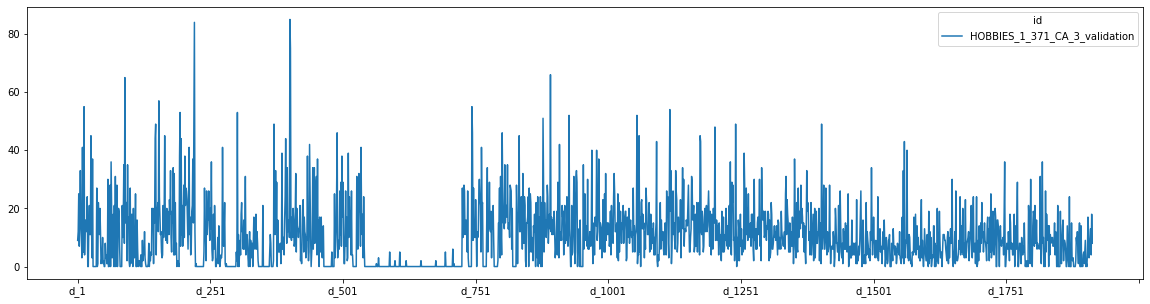

In [17]:
ex3.plot(figsize = (20,5))

In [18]:
# combine it with calendar data
ex3.index.rename('d', inplace = True)
ex3

id,HOBBIES_1_371_CA_3_validation
d,
d_1,9
d_2,12
d_3,25
d_4,7
d_5,17
...,...
d_1909,9
d_1910,13
d_1911,4


<AxesSubplot:xlabel='year'>

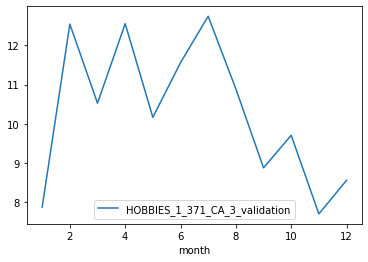

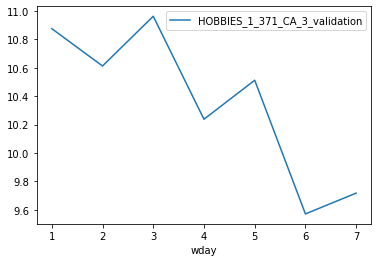

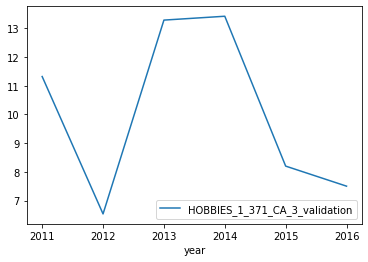

In [19]:
df_calendar
ex3_combined = pd.merge(df_calendar, ex3, on = 'd')
ex3_combined.groupby('month').mean().plot(y = 'HOBBIES_1_371_CA_3_validation')
ex3_combined.groupby('wday').mean().plot(y = 'HOBBIES_1_371_CA_3_validation')
ex3_combined.groupby('year').mean().plot(y = 'HOBBIES_1_371_CA_3_validation')


In [20]:
df_validation[df_validation['cat_id'] == 'HOUSEHOLD'][df_validation['store_id'] == 'CA_3'][d_col].sum(axis = 1).sort_values()

# index 6959 has large number of sales compared to others
df_validation.iloc[6959]

<ipython-input-20-ee0f205b6a60>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_validation[df_validation['cat_id'] == 'HOUSEHOLD'][df_validation['store_id'] == 'CA_3'][d_col].sum(axis = 1).sort_values()


id          HOUSEHOLD_1_303_CA_3_validation
item_id                     HOUSEHOLD_1_303
dept_id                         HOUSEHOLD_1
cat_id                            HOUSEHOLD
store_id                               CA_3
                         ...               
d_1909                                    7
d_1910                                   10
d_1911                                   18
d_1912                                   13
d_1913                                   14
Name: 6959, Length: 1919, dtype: object

In [21]:
ex4 = df_validation[df_validation['id'] == 'HOUSEHOLD_1_303_CA_3_validation'].set_index('id')[d_col]
ex4 = ex4.T
ex4

id,HOUSEHOLD_1_303_CA_3_validation
d_1,16
d_2,3
d_3,1
d_4,16
d_5,19
...,...
d_1909,7
d_1910,10
d_1911,18
d_1912,13


<AxesSubplot:>

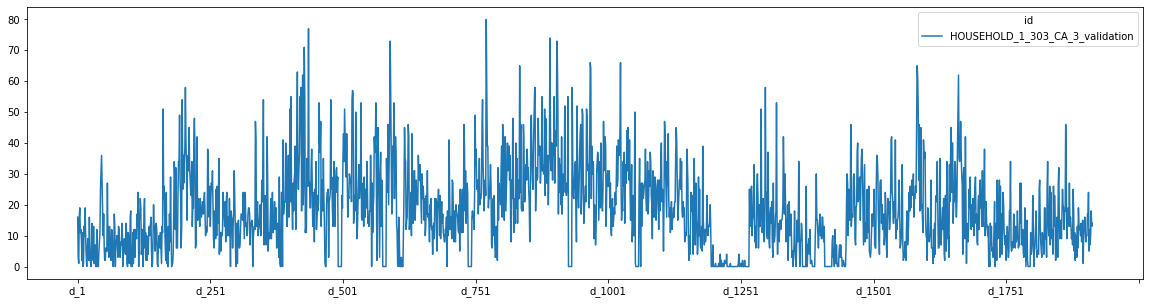

In [22]:
ex4.plot(figsize = (20,5))

<AxesSubplot:xlabel='wday'>

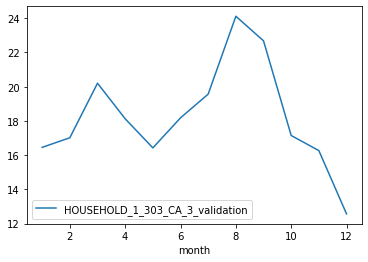

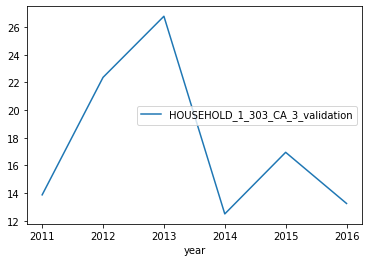

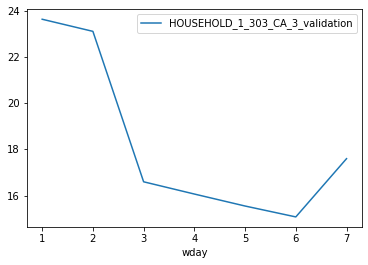

In [23]:
ex4.index.names = ['d']
ex4_combined = pd.merge(df_calendar, ex4, on = 'd')
ex4_combined.groupby('month').mean().plot(y='HOUSEHOLD_1_303_CA_3_validation')

ex4_combined.groupby('year').mean().plot(y='HOUSEHOLD_1_303_CA_3_validation')

ex4_combined.groupby('wday').mean().plot(y='HOUSEHOLD_1_303_CA_3_validation')


<AxesSubplot:xlabel='month'>

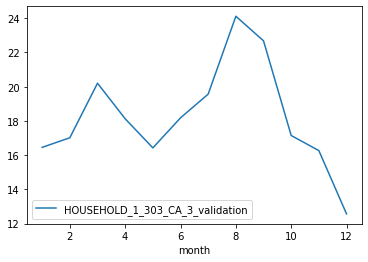

In [24]:
ex4_combined.groupby('month').mean().plot(y='HOUSEHOLD_1_303_CA_3_validation')

<AxesSubplot:title={'center':'Average sales by categories'}>

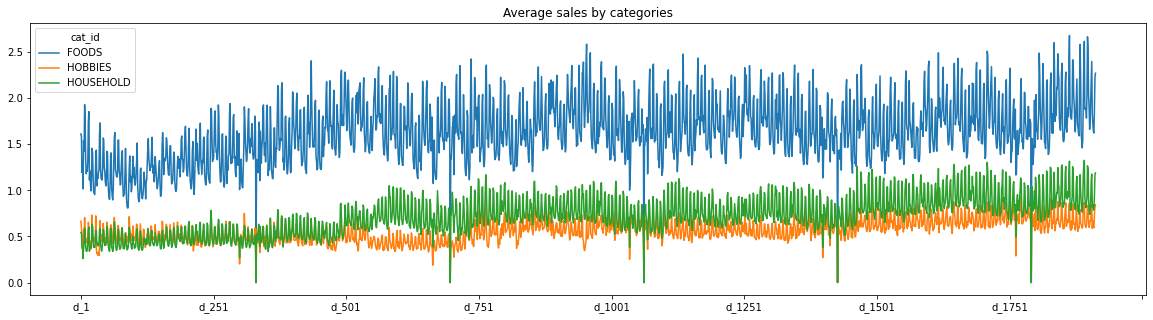

In [25]:
# number of sales by catergories

df_validation.groupby('cat_id').mean().T.plot(figsize = (20,5), title = 'Average sales by categories')

In [26]:
df_validation

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


<AxesSubplot:title={'center':'Total sales by categories'}>

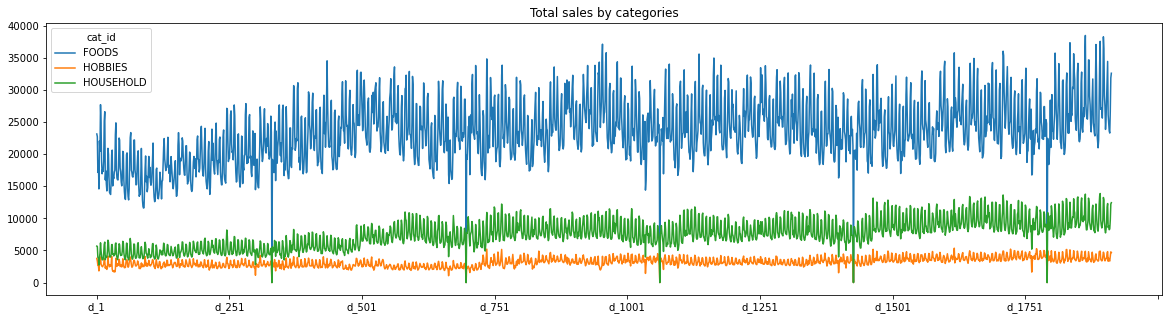

In [27]:
df_validation.groupby('cat_id').sum().T.plot(figsize=(20,5), title = 'Total sales by categories')

In [28]:
df_val_transposed = df_validation.set_index('id').T
df_val_transposed.index.rename('d', inplace = True)

df_validation_cal = pd.merge(df_val_transposed, df_calendar, on = 'd').set_index('date')

item_col = np.array(df_validation['id'])
item_col

df_validation_cal = df_validation_cal[item_col]

In [29]:
df_validation_cliped = df_validation_cal.clip(0,1)


In [30]:
df_validation_cliped

,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,1,1,0,...,0,1,1,0,1,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,1,0,0,...,0,1,1,0,1,0,0,1,0,0
2011-01-31,0,0,0,0,0,0,0,0,1,1,...,0,1,1,0,1,1,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,1,0,...,0,1,1,0,1,1,0,1,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,1,1,1,0,1,0,1,1,0,0,...,1,1,1,0,0,0,0,1,1,0
2016-04-21,1,0,0,1,1,0,0,1,0,0,...,1,1,1,0,1,1,0,0,0,0
2016-04-22,0,0,1,1,1,1,0,1,0,1,...,0,1,1,0,1,0,0,0,1,0


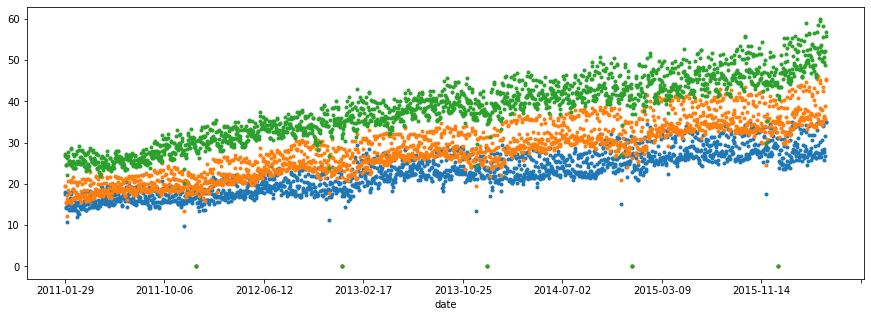

In [31]:
for i in df_validation['cat_id'].unique():
    items = [c for c in df_validation_cliped.columns if i in c]
    (df_validation_cliped[items].mean(axis=1)*100).plot(figsize=(15,5),style = '.')

<AxesSubplot:xlabel='cat_id'>

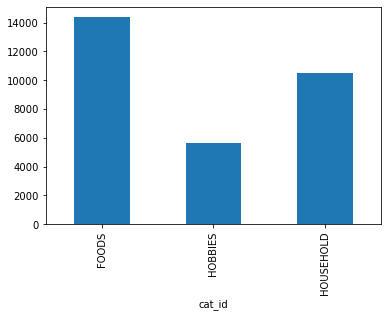

In [33]:
# counting the number of rows for each cat_id.
df_validation.groupby('cat_id').count()['id'].plot(kind='bar')

In [34]:
df_validation.set_index('id').T.loc[d_col]

id,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
d_1,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
d_2,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
d_3,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
d_4,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
d_5,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1909,1,1,1,0,1,0,1,4,0,0,...,4,1,1,0,0,0,0,1,1,0
d_1910,3,0,0,1,2,0,0,6,0,0,...,2,3,3,0,2,1,0,0,0,0
d_1911,0,0,1,3,2,2,0,3,0,2,...,0,1,6,0,3,0,0,0,3,0
d_1912,1,0,1,7,2,0,1,2,0,0,...,3,0,0,4,2,0,1,1,1,0


In [35]:
date_col = df_calendar.iloc[:,0]
date_col

0       2011-01-29
1       2011-01-30
2       2011-01-31
3       2011-02-01
4       2011-02-02
           ...    
1964    2016-06-15
1965    2016-06-16
1966    2016-06-17
1967    2016-06-18
1968    2016-06-19
Name: date, Length: 1969, dtype: object

In [36]:
df_validation.dept_id.unique()

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

In [37]:
# Price Dataframe

In [38]:
df_price = pd.read_csv('sell_prices.csv')
df_price

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [39]:
stores = np.array(df_price['store_id'].unique())
stores

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

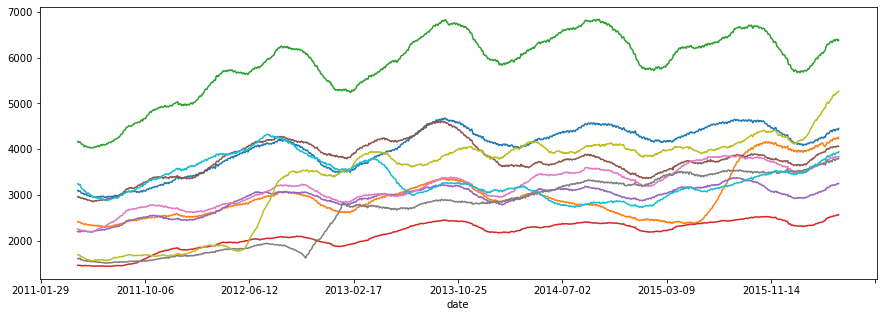

In [40]:
# Moving Average with window size 90
for store in stores:
    items = [c for c in df_validation_cal.columns if store in c]
    df_validation_cal[items].sum(axis = 1).rolling(90).mean().plot(figsize = (15,5))

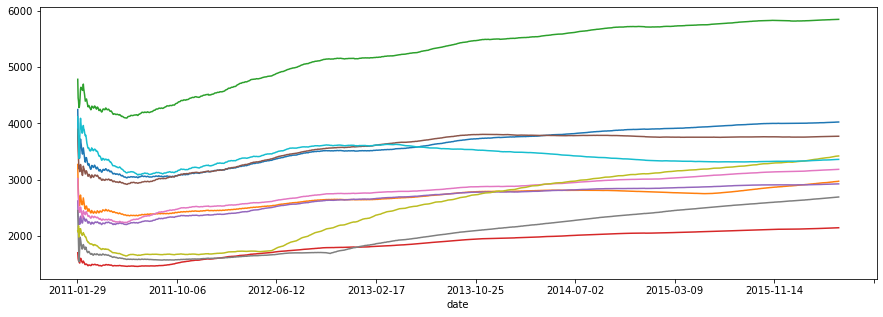

In [41]:
# Expanding Average (useless)
for store in stores:
    items = [c for c in df_validation_cal.columns if store in c]
    df_validation_cal[items].sum(axis = 1).expanding(2).mean().plot(figsize = (15,5))

<AxesSubplot:>

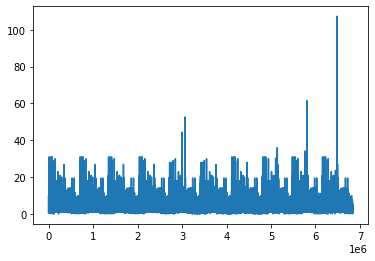

In [45]:
df_price['sell_price'].plot()

<ipython-input-46-011a9ce7a8a3>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_price[df_price['item_id'] == 'FOODS_3_090'][df_price['store_id'] == 'CA_3'].plot(x = 'wm_yr_wk', y='sell_price')


<AxesSubplot:xlabel='wm_yr_wk'>

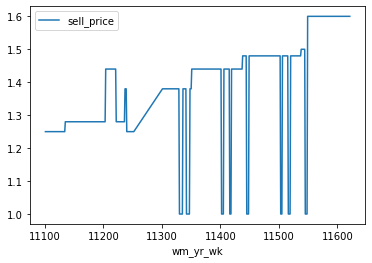

In [46]:
df_price[df_price['item_id'] == 'FOODS_3_090'][df_price['store_id'] == 'CA_3'].plot(x = 'wm_yr_wk', y='sell_price')

<AxesSubplot:xlabel='wm_yr_wk'>

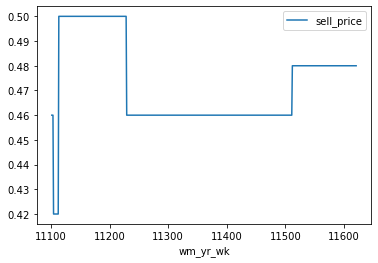

In [47]:
df_price[(df_price['item_id'] == 'HOBBIES_1_371') & (df_price['store_id']=='CA_3' )].plot(x='wm_yr_wk', y='sell_price')

In [50]:
df_price.item_id.unique().shape

(3049,)

In [51]:
for i in df_price[df_price['item_id'] == 'HOBBIES_1_001']:
    print(i)

store_id
item_id
wm_yr_wk
sell_price


In [54]:
df_price['dept_id'] = 'h'
df_price

,store_id,item_id,wm_yr_wk,sell_price,dept_id
0,CA_1,HOBBIES_1_001,11325,9.58,h
1,CA_1,HOBBIES_1_001,11326,9.58,h
2,CA_1,HOBBIES_1_001,11327,8.26,h
3,CA_1,HOBBIES_1_001,11328,8.26,h
4,CA_1,HOBBIES_1_001,11329,8.26,h
...,...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00,h
6841117,WI_3,FOODS_3_827,11618,1.00,h
6841118,WI_3,FOODS_3_827,11619,1.00,h
6841119,WI_3,FOODS_3_827,11620,1.00,h


In [ ]:
if item[:7] in df_price['item_id'] == 'HOBBIES':
        df_price['dept_id'] = 'HOBBIES'
else:
    df_price['dept_id'] = ''
df_price

In [ ]:
for item in df_price['item_id']:
    if item[:7] == 'HOBBIES':
        df_price['dept_id'] = 'HOBBIES'
        
df_price
#df_price[df_price['item_id'] == 'FOO']